In [1]:
import dgl

from Coarsener.HeteroRGCNCoarsener import HeteroRGCNCoarsener
from Data.ACM import ACM
import dgl.function as fn
import torch
import numpy as np
import torch_geometric
import Data.utils
torch.cuda.empty_cache()


/scratch/0994359/hetero-conv-matching/.venv/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


In [3]:

dataset = ACM() 
original_graph = dataset.load_graph(n_components=30)
device= "cuda:3"
original_graph = original_graph.to(device)
original_graph = Data.utils.create_random_mask(original_graph, device=device, target_ntype="paper") 

In [9]:

num_nearest_init_neighbors_per_type =  {"author": 50, "authortopaper": 50, "paper":50, "papertopaper":50,"papertopaper":50, "papertoauthor":50, "author":50 , "papertosubject":50, "subject": 50, "papertoterm":50, "term":50, "subjecttopaper":50, "termtopaper":50 }
from Projections.CCA import CCA
coarsener = HeteroRGCNCoarsener(original_graph, num_nearest_init_neighbors_per_type, use_zscore=False,device=device,
                                cca_cls=CCA, batch_size=None, checkpoints=[0.999, 0.5, 0.3,0.1], folder_name="acm_cca_pca_30_pair_5_2",
                                pairs_per_level=5,norm_p=1, approx_neigh=True, add_feat=True, use_out_degree=False) 

coarsener.init()

coarsener.summarize()

/scratch/0994359/hetero-conv-matching/.venv/lib64/python3.9/site-packages/dgl/transforms/functional.py:1366: DGLWarning: share_ndata argument has been renamed to copy_ndata.
  dgl_warning("share_ndata argument has been renamed to copy_ndata.")


authortopaper
papertoauthor
papertopaper
papertosubject
papertoterm
subjecttopaper
termtopaper
step: 0, ratio: 1.0
step: 1, ratio: 0.9995430451471394
step: 2, ratio: 0.999086090294279
step: 3, ratio: 0.9986291354414184
step: 4, ratio: 0.9981721805885578
step: 5, ratio: 0.9977152257356973
step: 6, ratio: 0.9972582708828368
step: 7, ratio: 0.9968013160299762
step: 8, ratio: 0.9963443611771157
step: 9, ratio: 0.9958874063242552
step: 10, ratio: 0.9954304514713946
step: 11, ratio: 0.9949734966185341
step: 12, ratio: 0.9945165417656735
step: 13, ratio: 0.994059586912813
step: 14, ratio: 0.9936026320599525
step: 15, ratio: 0.9931456772070919
step: 16, ratio: 0.9926887223542314
step: 17, ratio: 0.9922317675013709
step: 18, ratio: 0.9917748126485103
step: 19, ratio: 0.9913178577956497
step: 20, ratio: 0.9908609029427893
step: 21, ratio: 0.9904039480899287
step: 22, ratio: 0.9899469932370681
step: 23, ratio: 0.9894900383842077
step: 24, ratio: 0.9890330835313471
step: 25, ratio: 0.9885761286784

In [22]:
X =coarsener.summarized_graph.nodes['author'].data['feat_pca']
Y = coarsener.summarized_graph.nodes['author'].data["hauthortopaper"]

In [21]:
coarsener.summarized_graph.nodes['author'].data.keys()

dict_keys(['feat_pca', 'feat', 'node_size', 'deg_authortopaper', 'deg_papertoauthor', 'sauthortopaper', 'hauthortopaper', 'iauthortopaper'])

In [23]:
coarsener.summarized_graph.nodes['paper']
X_c, Y_c = coarsener.ccas['authortopaper'].transform(X,Y)
X_c, Y_c = X_c.to('cpu'), Y_c.to('cpu')
canonical_corrs = [np.corrcoef(X_c[:, i], Y_c[:, i])[0, 1] for i in range(2)]
print("Canonical Correlations:", canonical_corrs)

Canonical Correlations: [0.8955351456160081, 0.940887152016704]


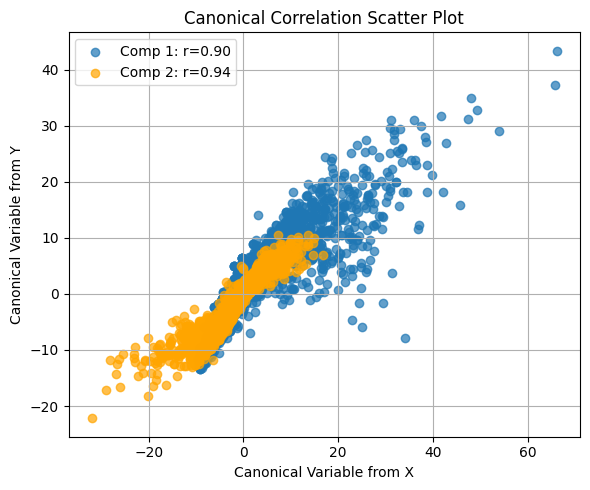

In [25]:

import matplotlib.pyplot as plt
# Scatter plot of canonical variates
plt.figure(figsize=(6, 5))
plt.scatter(X_c[:, 0], Y_c[:, 0], label=f"Comp 1: r={canonical_corrs[0]:.2f}", alpha=0.7)
plt.scatter(X_c[:, 1], Y_c[:, 1], label=f"Comp 2: r={canonical_corrs[1]:.2f}", alpha=0.7, color='orange')
plt.xlabel("Canonical Variable from X")
plt.ylabel("Canonical Variable from Y")
plt.title("Canonical Correlation Scatter Plot")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [3]:

import pickle
with open(f'results/acm_cca_pca_30/0.3', 'rb') as fh:
        
    coarsener = pickle.load(fh) 

In [10]:
import torch
coarsend_graph = coarsener.summarized_graph
coarsend_graph = coarsend_graph.to(device)
#coarsend_graph = coarsend_graph.cpu()
mapping = coarsener.get_mapping("paper")
coarsener.make_mask(mapping, "paper")

labels = coarsener.get_labels(mapping, "paper")
coarsend_graph.nodes["paper"].data["label"] = torch.tensor([labels[i] for i in range(len(labels)) ],  device=device) #,
print("ratio", coarsend_graph.num_nodes()/ original_graph.num_nodes() ) 


ratio 0.09998172180588558


torch.Size([30, 30])

In [11]:
from Models.SimpleHeteroGCN import HeteroGCNCiteer    
from Models.ImprovedGCN import ImprovedGCN
from Models.HeteroSGC import HeteroSGC
import importlib
from Models.HeteroSage import HeteroSAGE

from Models.HeteroSGC import HeteroSGCPaper
from Experiments.model_helper import run_experiments
from Experiments.plots import plot_bar, plot_line
orig, coar, loss_ori, loss_coar = run_experiments(original_graph, coarsend_graph,   ImprovedGCN, num_runs=1,
                                                  model_param={"hidden_dim": 64,"num_layers":4,} ,
                        optimizer_param={"lr": 0.001, "weight_decay": 5e-4}, epochs=200,eval_interval=1, target_node_type="paper", device="cuda:3")
orig_short = [ o[-1] for o in orig ]
coar_short = [ o[-1] for o in coar ]


In [12]:
max(orig[0]), max(coar[0])

(0.9454545454545454, 0.9024793388429752)